In [3]:
    !unzip /content/Micostructures.zip

Archive:  /content/Micostructures.zip
  inflating: Microstructures/solved_rubiks_cube.webp  
  inflating: Microstructures/cr_lcs.png  
  inflating: Microstructures/cr_lcs_ferrite_30.png  
  inflating: Microstructures/cr_lcs_ferrite_90.png  
  inflating: Microstructures/cr_lcs_ferrite_70.png  
  inflating: Microstructures/White_highchromium_iron_inc.png  
  inflating: Microstructures/White_highchromium_iron.png  
  inflating: Microstructures/proprietarysteel_cast_ht.png  
  inflating: Microstructures/cr_lcs_ferrite_50.png  
  inflating: Microstructures/White_highchromium_iron_c.png  


# Demo 1: FFT-Based Denoising

This demo shows how to denoise microscopy images by keeping only the most significant frequency components from the Fourier transform.

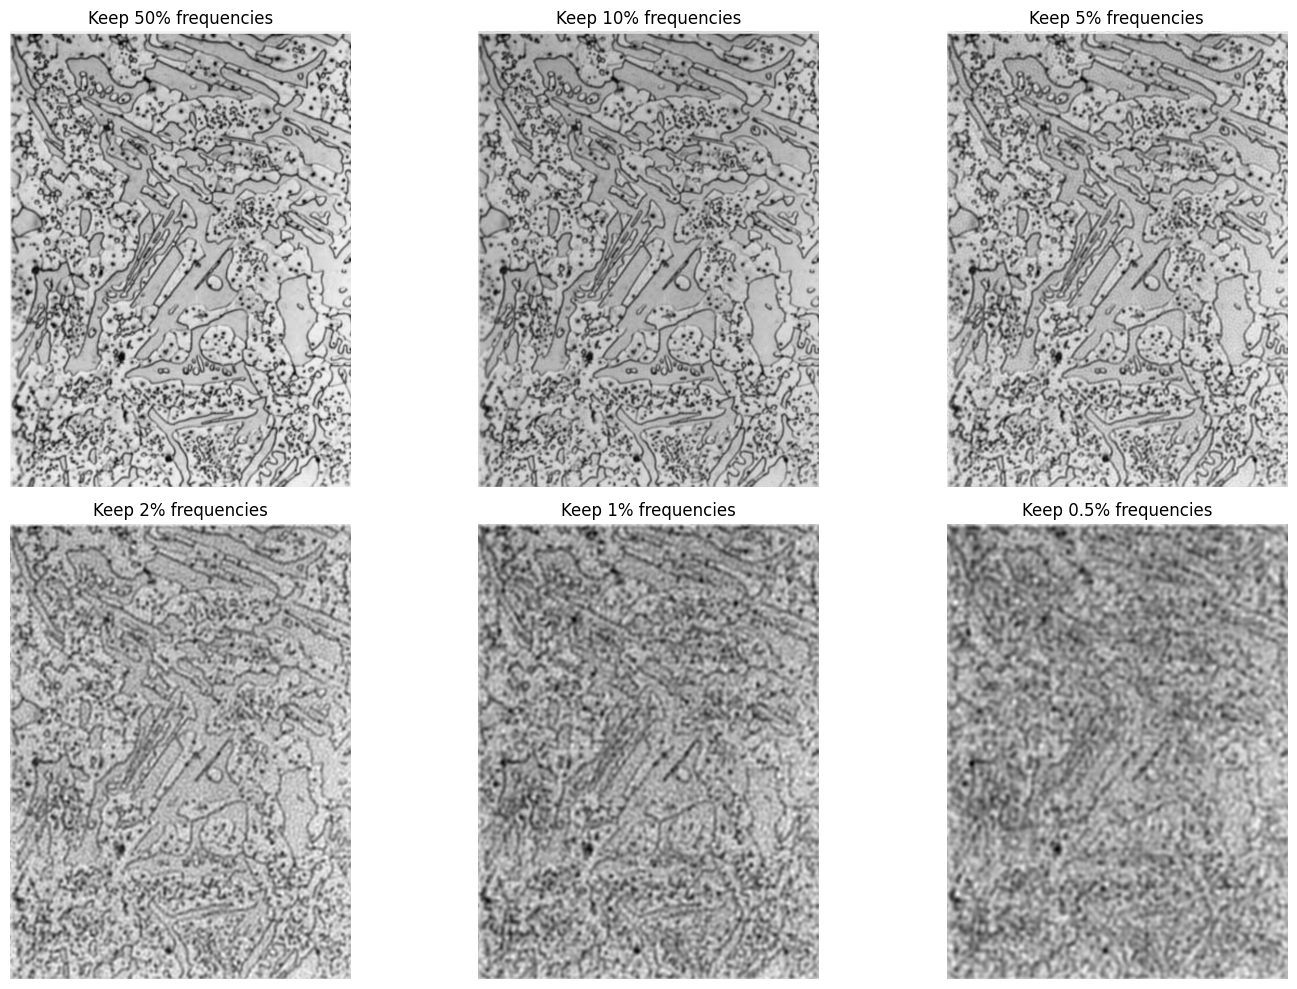

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio

def fft_denoise_image(img, percentile_keep=10):
    """
    Denoise an image by keeping only the highest-magnitude frequency components.

    This works because:
    - Signal (real features) tends to have high-magnitude frequency components
    - Noise tends to be distributed across many low-magnitude frequencies

    Args:
        img: 2D grayscale image array
        percentile_keep: Percentage of highest-magnitude frequencies to keep (default 10%)

    Returns:
        denoised_img: The reconstructed image with noise removed
        mask: Binary mask showing which frequencies were kept
    """
    # Transform image to frequency domain using 2D Fast Fourier Transform
    # This converts spatial information into frequency information
    fft_img = np.fft.fft2(img)

    # Shift zero-frequency component to center of spectrum
    # This makes visualization easier and puts DC component (average intensity) in the middle
    fft_shift = np.fft.fftshift(fft_img)

    # Calculate magnitude of each frequency component
    # Magnitude tells us how important each frequency is to the image
    magnitude = np.abs(fft_shift)

    # Determine threshold keeping only the top X% of frequencies by magnitude
    # For example, if percentile_keep=10, we keep only frequencies above the 90th percentile
    threshold = np.percentile(magnitude, 100 - percentile_keep)

    # Create binary mask, True for frequencies above threshold, False otherwise
    mask = magnitude > threshold

    # Apply mask to filtered FFT (zeroes out low-magnitude frequencies)
    fft_filtered = fft_shift * mask

    # Transform back to spatial domain
    # First unshift to restore original FFT layout, then apply inverse FFT
    img_denoised = np.fft.ifft2(np.fft.ifftshift(fft_filtered))

    # Take absolute value to get real-valued image (removes any residual imaginary components)
    return np.abs(img_denoised), mask

# MAIN EXECUTION: Compare different levels of frequency compression

# Load the microscopy image
img = iio.imread('/content/Microstructures/White_highchromium_iron_c.png')

# Convert to grayscale if image is RGB (has 3 color channels)
# We average across the color dimension (axis=2) to get a single intensity value per pixel
if len(img.shape) == 3:
    img = np.mean(img, axis=2)

# Create a 2x3 grid of subplots to show results at different compression levels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Test different compression levels from mild (50%) to aggressive (0.5%)
# Lower percentages = more aggressive denoising (fewer frequencies kept)
for idx, keep_pct in enumerate([50, 10, 5, 2, 1, 0.5]):
    # Denoise image keeping only top keep_pct% of frequencies
    denoised, mask = fft_denoise_image(img, keep_pct)

    # Calculate subplot position in 2x3 grid
    row = idx // 3  # Integer division gives row (0 or 1)
    col = idx % 3   # Modulo gives column (0, 1, or 2)

    # Display the denoised image
    axes[row, col].imshow(denoised, cmap='gray')
    axes[row, col].set_title(f'Keep {keep_pct}% frequencies')
    axes[row, col].axis('off')  # Hide axis ticks for cleaner visualization

plt.tight_layout()
plt.savefig('denoising_comparison.png', dpi=300)
plt.show()

# Demo 2: Bandpass Filtering for Feature Separation

This demo uses bandpass filtering to separate microstructural features by size. Different spatial frequencies correspond to different feature sizes:
- Low frequencies = large features (grain structure)
- Medium frequencies = medium-sized features
- High frequencies = fine features (precipitates, grain boundaries)

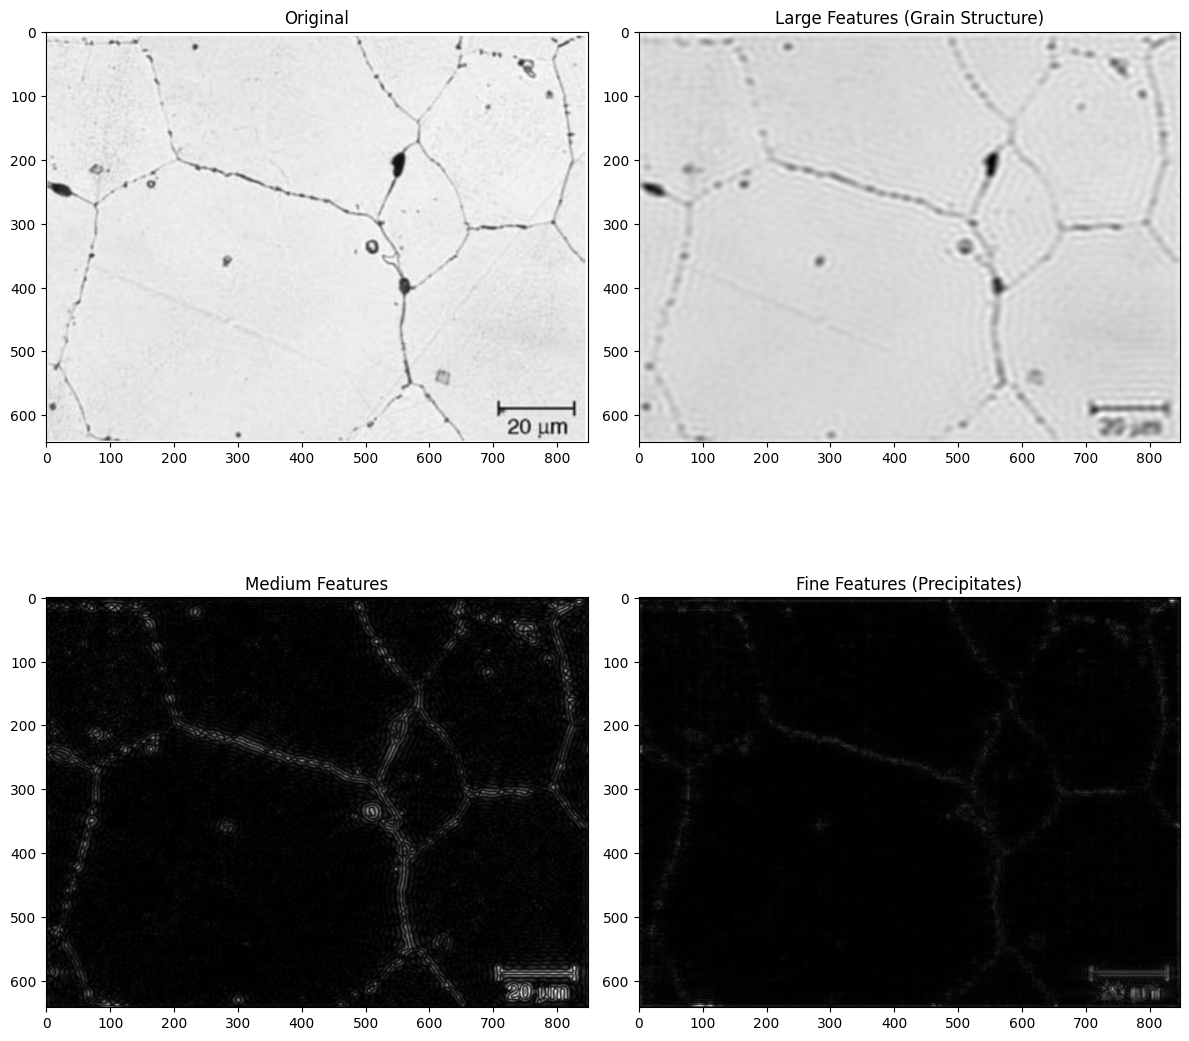

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio

def frequency_filter(img, cutoff_low, cutoff_high):
    """
    Apply a bandpass filter to isolate features within a specific size range.

    The filter works in frequency space using a circular mask:
    - Frequencies inside the radius range are kept (pass band)
    - Frequencies outside the range are removed (stop band)

    Args:
        img: 2D grayscale image array
        cutoff_low: Inner radius of bandpass filter (pixels from center)
        cutoff_high: Outer radius of bandpass filter (pixels from center)

    Returns:
        filtered_img: Image containing only features in the specified size range
    """
    # Transform to frequency domain
    fft_img = np.fft.fft2(img)

    # Shift zero-frequency to center for easier radial filtering
    fft_shift = np.fft.fftshift(fft_img)

    # Get image dimensions and calculate center coordinates
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2  # Center row and center column

    # Create a radial distance map from the center
    # np.ogrid creates coordinate arrays without creating full meshgrids (memory efficient)
    y, x = np.ogrid[:rows, :cols]

    # Calculate Euclidean distance from each point to the center
    # This gives us the radial frequency (distance from DC component)
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2)

    # Create circular bandpass mask
    # Keep only frequencies where distance is between cutoff_low and cutoff_high
    # This creates a "donut" or annular region in frequency space
    mask = (dist >= cutoff_low) & (dist <= cutoff_high)

    # Apply mask to frequency data (element-wise multiplication)
    fft_filtered = fft_shift * mask

    # Transform back to spatial domain
    # Unshift to restore original layout, then apply inverse FFT
    img_filtered = np.fft.ifft2(np.fft.ifftshift(fft_filtered))

    # Return absolute value to get real-valued result
    return np.abs(img_filtered)

# MAIN EXECUTION: Separate features by size using frequency bands

# Load microscopy image
img = iio.imread('/content/Microstructures/proprietarysteel_cast_ht.png')

# Convert to grayscale if needed
if len(img.shape) == 3:
    img = np.mean(img, axis=2)

# Apply bandpass filters at three different frequency ranges
# Lower cutoff values = lower frequencies = larger spatial features
# Higher cutoff values = higher frequencies = smaller spatial features

# Extract large features: 0-50 pixels radius in frequency space
# These correspond to the overall grain structure and morphology
large_features = frequency_filter(img, 0, 50)

# Extract medium features: 50-150 pixels radius
# These capture intermediate-sized structures
medium_features = frequency_filter(img, 50, 150)

# Extract fine features: 150-300 pixels radius
# These reveal fine details like precipitates and grain boundaries
fine_features = frequency_filter(img, 150, 300)

# Create 2x2 visualization grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Display original image (top-left)
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')

# Display large features (top-right)
axes[0, 1].imshow(large_features, cmap='gray')
axes[0, 1].set_title('Large Features (Grain Structure)')

# Display medium features (bottom-left)
axes[1, 0].imshow(medium_features, cmap='gray')
axes[1, 0].set_title('Medium Features')

# Display fine features (bottom-right)
axes[1, 1].imshow(fine_features, cmap='gray')
axes[1, 1].set_title('Fine Features (Precipitates)')

plt.tight_layout()
plt.savefig('feature_separation.png', dpi=300)
plt.show()

# Demo 3: Anisotropy Detection in Cold-Rolled Steel

This demo quantifies directional preference (anisotropy) in microstructures by analyzing angular distribution of power in frequency space.

**Key Concept**: In FFT space, there's a 90° rotation relationship:
- Horizontal banding in real space → Vertical power concentration in FFT
- Vertical features in real space → Horizontal power concentration in FFT

The Anisotropy Index (AI) is calculated as: AI = vertical_power / horizontal_power
- AI > 1: Horizontal banding (typical in cold-rolled materials)
- AI < 1: Vertical features dominate
- AI ≈ 1: Isotropic (no preferred direction)

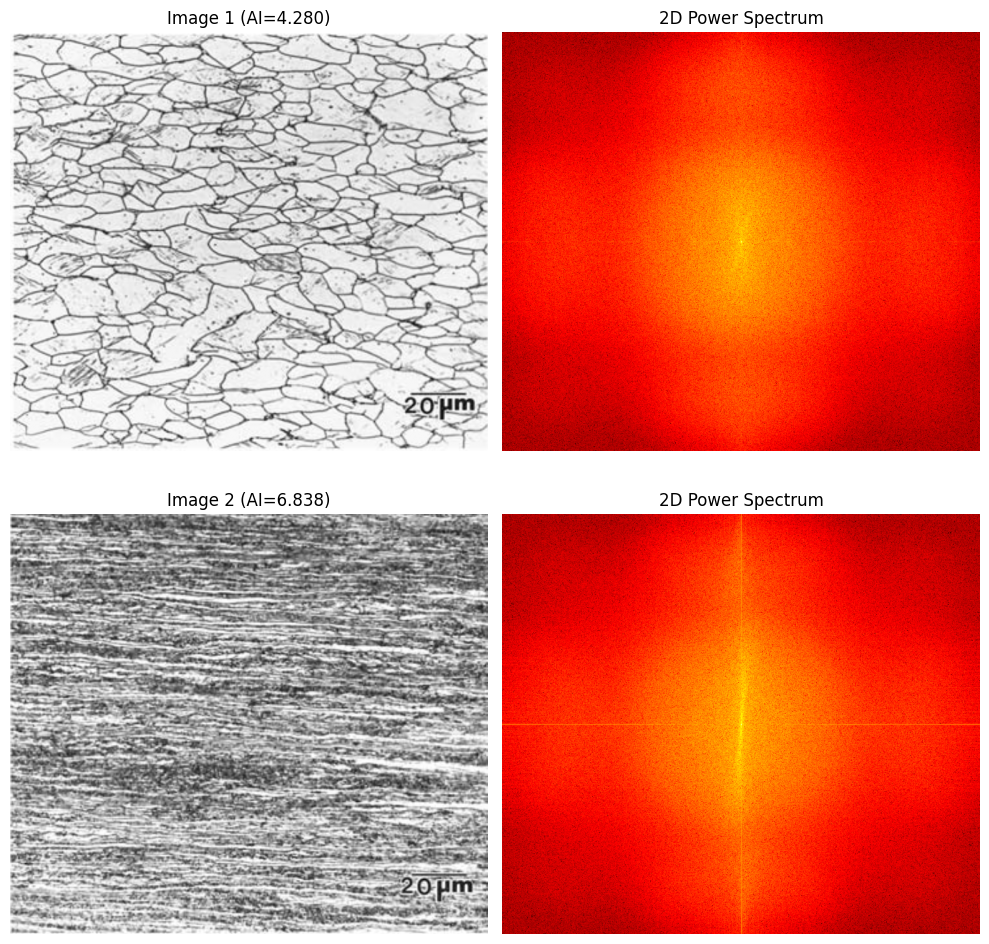


ANISOTROPY DETECTION
Image 1 (30% rolled): AI = 4.280
Image 2 (90% rolled): AI = 6.838
Difference: 2.558

Interpretation:
  AI > 1.0 → Horizontal banding (more cold rolling)
  AI < 1.0 → Vertical features
  AI ≈ 1.0 → Isotropic (no preferred direction)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

def compute_sectoral_anisotropy(img, sector_angle=30):
    """
    Compute microstructural anisotropy by comparing power in angular sectors.

    This method divides the FFT into sectors and compares power distribution
    along different directions to quantify directional preferences.

    Args:
        img: 2D grayscale image array
        sector_angle: Half-width of sectors in degrees (default 30°)
                     e.g., 30° creates 60° wide sectors centered on cardinal directions

    Returns:
        anisotropy_index: Ratio of vertical to horizontal power (AI)
        psd: 2D power spectral density array
        horizontal_mask: Boolean mask for horizontal sector
        vertical_mask: Boolean mask for vertical sector
    """
    # Compute 2D Fourier Transform and Power Spectral Density
    # Transform to frequency domain
    fft_img = np.fft.fft2(img)

    # Shift zero-frequency to center
    fft_shift = np.fft.fftshift(fft_img)

    # Calculate power spectral density (PSD = |FFT|²)
    # PSD represents the power (intensity) at each frequency and direction
    psd = np.abs(fft_shift)**2

    # Create coordinate system centered at frequency space origin

    rows, cols = psd.shape
    center_y, center_x = rows // 2, cols // 2

    # Create coordinate grids (memory-efficient method)
    y, x = np.ogrid[:rows, :cols]

    # Shift coordinates so (0,0) is at the center of the FFT
    y = y - center_y
    x = x - center_x

    # Calculate angular position for every point in frequency space

    # Compute angle from center using arctan2 (handles all quadrants correctly)
    # arctan2(y, x) returns angle in radians, converted to degrees
    # Angle convention: 0° = right (positive x), 90° = up (positive y)
    angles = np.degrees(np.arctan2(y, x))

    # Define angular sectors for horizontal and vertical directions

    # HORIZONTAL SECTOR: captures frequencies around 0° and 180° (±sector_angle)
    # These frequencies correspond to VERTICAL features in real space (90° rotated)
    # The | operator combines two conditions with logical OR
    horizontal_mask = ((angles >= -sector_angle) & (angles <= sector_angle)) | \
                     ((angles >= 180-sector_angle) | (angles <= -180+sector_angle))

    # VERTICAL SECTOR: captures frequencies around ±90° (±sector_angle)
    # These frequencies correspond to HORIZONTAL features in real space (90° rotated)
    vertical_mask = ((angles >= 90-sector_angle) & (angles <= 90+sector_angle)) | \
                   ((angles >= -90-sector_angle) & (angles <= -90+sector_angle))

    # Calculate mean power in each sector (excluding DC component)

    # Create mask to exclude the DC component (zero frequency at center)
    # The DC component represents average image intensity and can bias results
    # We exclude a 5-pixel radius circle around the center
    center_mask = np.sqrt(x**2 + y**2) > 5

    # Calculate average power in horizontal sector (excluding center)
    # The & operator combines masks element-wise with logical AND
    horizontal_power = np.mean(psd[horizontal_mask & center_mask])

    # Calculate average power in vertical sector (excluding center)
    vertical_power = np.mean(psd[vertical_mask & center_mask])

    # Compute Anisotropy Index

    # Anisotropy Index = vertical_power / horizontal_power
    #
    # IMPORTANT: Due to 90° rotation in FFT:
    # - High vertical power in FFT → horizontal banding in real space
    # - High horizontal power in FFT → vertical features in real space
    #
    # Therefore:
    # - AI > 1.0 → Horizontal features/banding (common in rolled materials)
    # - AI < 1.0 → Vertical features dominate
    # - AI ≈ 1.0 → Isotropic (no directional preference)
    anisotropy_index = vertical_power / horizontal_power

    return anisotropy_index, psd, horizontal_mask, vertical_mask


# MAIN EXECUTION: Compare anisotropy in steel with different rolling reductions

# Set up figure with 2 rows (one per image) and 2 columns (original + FFT)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Store anisotropy indices for comparison
anisotropy_indices = []

# Define image paths
# These are cold-rolled low carbon steel samples with different rolling reductions
image_paths = [
    '/content/Microstructures/cr_lcs_ferrite_30.png',  # 30% cold rolled
    '/content/Microstructures/cr_lcs_ferrite_90.png'   # 90% cold rolled
]

# Process each image
for idx, img_path in enumerate(image_paths):
    # Load image
    img = imread(img_path)

    # Convert RGB to grayscale if necessary
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)

    # Compute anisotropy using 30° sectors (60° total width)
    ai, psd, h_mask, v_mask = compute_sectoral_anisotropy(img, sector_angle=30)
    anisotropy_indices.append(ai)

    # Visualization: Original image (left column)
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'Image {idx+1} (AI={ai:.3f})')
    axes[idx, 0].axis('off')

    # Visualization: Power spectrum (right column)
    # Use logarithmic scale for better visualization: log(PSD + 1)
    # Adding 1 prevents log(0) issues and compresses dynamic range
    # 'hot' colormap shows high power as bright (white/yellow)
    axes[idx, 1].imshow(np.log(psd + 1), cmap='hot')
    axes[idx, 1].set_title('2D Power Spectrum')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.savefig('improved_anisotropy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print quantitative results
print(f"\n{'='*50}")
print(f"ANISOTROPY DETECTION")
print(f"{'='*50}")
print(f"Image 1 (30% rolled): AI = {anisotropy_indices[0]:.3f}")
print(f"Image 2 (90% rolled): AI = {anisotropy_indices[1]:.3f}")
print(f"Difference: {abs(anisotropy_indices[1] - anisotropy_indices[0]):.3f}")
print(f"\nInterpretation:")
print(f"  AI > 1.0 → Horizontal banding (more cold rolling)")
print(f"  AI < 1.0 → Vertical features")
print(f"  AI ≈ 1.0 → Isotropic (no preferred direction)")